# Human Spleen CODEX + RNA-seq Integration with MaxFuse and MARIO

This notebook integrates human spleen CODEX protein data (exported as TSV from QuPath) with scRNA-seq data using **both MaxFuse and MARIO** methods for comparison.

## Data Sources
- **CODEX**: `data/1904CC2B_cells.tsv` - freshly exported spleen CODEX data with 26 protein markers
- **RNA-seq**: Raw unfiltered 10x data from `data/raw_feature_bc_matrix/` (includes empty droplets)

## Pipeline Overview
1. Load and preprocess CODEX data from TSV
2. Load and filter raw RNA-seq data (cell calling from raw counts)
3. Build protein-gene correspondence
4. **MARIO: Matchability test** (pre-integration diagnostic)
5. **MARIO: Integration with interpolation** (optimal weight search)
6. **MaxFuse: Integration pipeline**
7. **Compare results** from both methods
8. Transfer cell type labels from RNA to spatial CODEX coordinates

## Methods
- **MARIO**: Uses overlapping features for initial matching, CCA refinement, weight interpolation, and joint regularized clustering
- **MaxFuse**: Uses graph smoothing, iterative CCA refinement, and pivot-based propagation

In [1]:
import numpy as np
import pandas as pd
from scipy.io import mmread
from scipy import sparse

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

import anndata as ad
import scanpy as sc

# Import from maxfuse package
from maxfuse import Mario
from maxfuse.mario.match import pipelined_mario

import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
np.random.seed(42)

print(f"MaxFuse package loaded")
print(f"MARIO loaded from maxfuse.mario")
print(f"Scanpy version: {sc.__version__}")

MaxFuse package loaded
MARIO loaded from maxfuse.mario
Scanpy version: 1.11.5


## Step 1: Load and Preprocess CODEX Data

The CODEX data is exported from QuPath as a TSV file with cell measurements.
We extract:
- Cell centroids (X, Y coordinates)
- Mean protein intensities for each marker

In [11]:
# Load CODEX data from TSV
codex_df = pd.read_csv('data/6551_cells.csv')
print(f"CODEX data shape: {codex_df.shape}")
print(f"Columns: {len(codex_df.columns)}")

CODEX data shape: (1900754, 1501)
Columns: 1501


In [12]:
# Identify protein marker columns (Cell: *: Mean)
marker_cols = [col for col in codex_df.columns if col.startswith('Cell:') and col.endswith(': Mean')]
print(f"Found {len(marker_cols)} protein markers:")
for col in marker_cols:
    # Extract marker name from column name like "Cell: CD1c (C1): Mean"
    marker = col.split(':')[1].strip().split('(')[0].strip()
    print(f"  {marker}")

Found 59 protein markers:
  DAPI
  IAPP
  CD107a
  CD4
  CD31
  SMA
  CD68
  CD44
  Vimentin
  CD99
  E-cadherin
  IDO1
  CD66
  INS
  Ker8-18
  CD11c
  CD38
  HLA-DR
  CD34
  iNOS
  M2Gal3
  B3TUBB
  CD8
  PCNA
  FOXP3
  CD57
  Ki67
  Granzyme B
  HLA-A
  CD20
  Collagen IV
  VISTA
  Pan-Cytokeratin
  PD-1
  LAG3
  SST
  TCF-1
  TOX
  Caveolin
  ICOS
  CD163
  EpCAM
  PD-L1
  CD79a
  Keratin 5
  CD3e
  GCG
  Beta-actin
  Bcl-2
  MPO
  CD56
  CD39
  Iba1
  SOX2
  CD209
  Podoplanin
  CD11b
  CD206
  TP63


In [13]:
# Extract marker names and build protein expression matrix
marker_names = []
for col in marker_cols:
    # Parse "Cell: CD1c (C1): Mean" -> "CD1c"
    marker = col.split(':')[1].strip().split('(')[0].strip()
    marker_names.append(marker)

# Create protein expression matrix
protein_matrix = codex_df[marker_cols].values
print(f"Protein matrix shape: {protein_matrix.shape}")
print(f"Markers: {marker_names}")

Protein matrix shape: (1900754, 59)
Markers: ['DAPI', 'IAPP', 'CD107a', 'CD4', 'CD31', 'SMA', 'CD68', 'CD44', 'Vimentin', 'CD99', 'E-cadherin', 'IDO1', 'CD66', 'INS', 'Ker8-18', 'CD11c', 'CD38', 'HLA-DR', 'CD34', 'iNOS', 'M2Gal3', 'B3TUBB', 'CD8', 'PCNA', 'FOXP3', 'CD57', 'Ki67', 'Granzyme B', 'HLA-A', 'CD20', 'Collagen IV', 'VISTA', 'Pan-Cytokeratin', 'PD-1', 'LAG3', 'SST', 'TCF-1', 'TOX', 'Caveolin', 'ICOS', 'CD163', 'EpCAM', 'PD-L1', 'CD79a', 'Keratin 5', 'CD3e', 'GCG', 'Beta-actin', 'Bcl-2', 'MPO', 'CD56', 'CD39', 'Iba1', 'SOX2', 'CD209', 'Podoplanin', 'CD11b', 'CD206', 'TP63']


In [14]:
# Extract spatial coordinates
# Look for centroid columns
x_col = [col for col in codex_df.columns if 'Centroid X' in col][0]
y_col = [col for col in codex_df.columns if 'Centroid Y' in col][0]
print(f"X coordinate column: {x_col}")
print(f"Y coordinate column: {y_col}")

x_coords = codex_df[x_col].values
y_coords = codex_df[y_col].values
print(f"\nSpatial extent:")
print(f"  X: {x_coords.min():.1f} - {x_coords.max():.1f}")
print(f"  Y: {y_coords.min():.1f} - {y_coords.max():.1f}")

X coordinate column: Centroid X µm
Y coordinate column: Centroid Y µm

Spatial extent:
  X: 0.6 - 24862.9
  Y: 23.2 - 29630.1


In [15]:
# Create AnnData object for protein data
protein_adata = ad.AnnData(protein_matrix.astype(np.float32))
protein_adata.var_names = marker_names
protein_adata.obs['X_centroid'] = x_coords
protein_adata.obs['Y_centroid'] = y_coords
protein_adata.obs_names = [f"cell_{i}" for i in range(protein_adata.n_obs)]

print(f"Protein AnnData: {protein_adata.shape}")
print(f"Markers: {list(protein_adata.var_names)}")

Protein AnnData: (1900754, 59)
Markers: ['DAPI', 'IAPP', 'CD107a', 'CD4', 'CD31', 'SMA', 'CD68', 'CD44', 'Vimentin', 'CD99', 'E-cadherin', 'IDO1', 'CD66', 'INS', 'Ker8-18', 'CD11c', 'CD38', 'HLA-DR', 'CD34', 'iNOS', 'M2Gal3', 'B3TUBB', 'CD8', 'PCNA', 'FOXP3', 'CD57', 'Ki67', 'Granzyme B', 'HLA-A', 'CD20', 'Collagen IV', 'VISTA', 'Pan-Cytokeratin', 'PD-1', 'LAG3', 'SST', 'TCF-1', 'TOX', 'Caveolin', 'ICOS', 'CD163', 'EpCAM', 'PD-L1', 'CD79a', 'Keratin 5', 'CD3e', 'GCG', 'Beta-actin', 'Bcl-2', 'MPO', 'CD56', 'CD39', 'Iba1', 'SOX2', 'CD209', 'Podoplanin', 'CD11b', 'CD206', 'TP63']


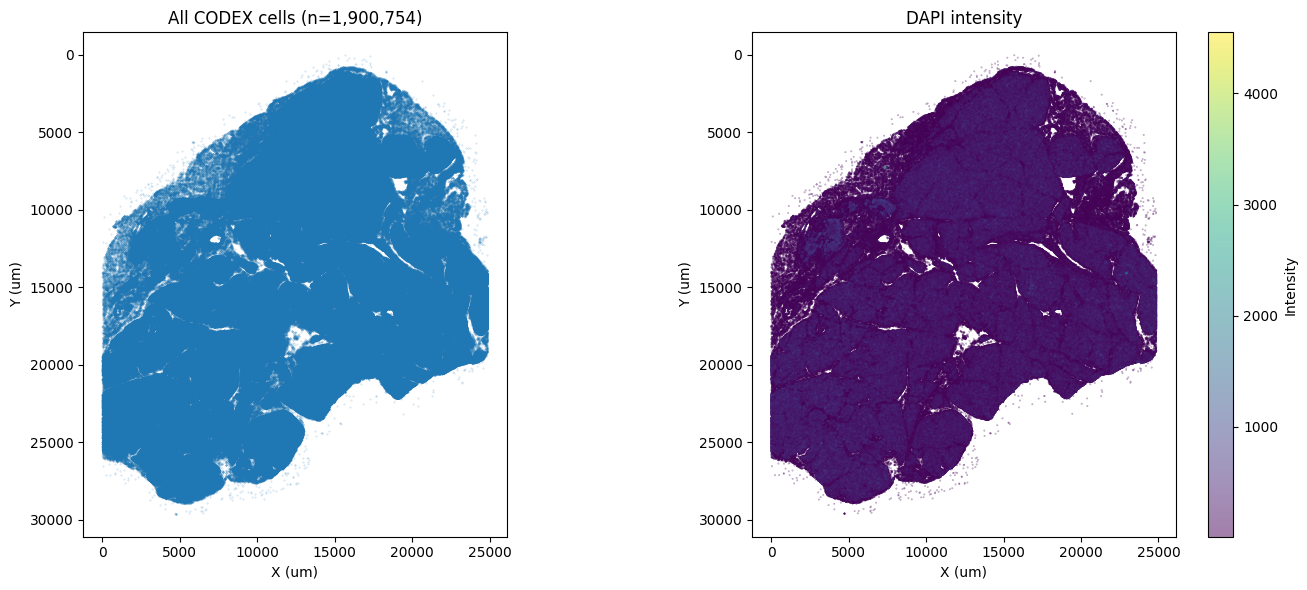

In [16]:
# Quick spatial visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot all cells
axes[0].scatter(x_coords, y_coords, s=0.1, alpha=0.3)
axes[0].set_xlabel('X (um)')
axes[0].set_ylabel('Y (um)')
axes[0].set_title(f'All CODEX cells (n={len(x_coords):,})')
axes[0].set_aspect('equal')
axes[0].invert_yaxis()
# Plot with CD45 intensity
cd45_idx = marker_names.index('CD45') if 'CD45' in marker_names else 0
scatter = axes[1].scatter(x_coords, y_coords, c=protein_matrix[:, cd45_idx], 
                          s=0.1, alpha=0.5, cmap='viridis')
axes[1].set_xlabel('X (um)')
axes[1].set_ylabel('Y (um)')
axes[1].set_title(f'{marker_names[cd45_idx]} intensity')
axes[1].set_aspect('equal')
plt.colorbar(scatter, ax=axes[1], label='Intensity')
axes[1].invert_yaxis()
plt.tight_layout()
plt.show()

In [17]:
# Diagnostic: Explore CODEX data quality metrics
# QuPath exports many morphology features we can use for filtering

print("Available columns in CODEX data:")
print("="*60)

# Group columns by type
morphology_cols = [c for c in codex_df.columns if 'Area' in c or 'Perimeter' in c or 
                   'Circularity' in c or 'Solidity' in c or 'Eccentricity' in c]
intensity_cols = [c for c in codex_df.columns if 'Mean' in c or 'Median' in c or 'Max' in c]
location_cols = [c for c in codex_df.columns if 'Centroid' in c or 'centroid' in c]

print(f"\nMorphology columns ({len(morphology_cols)}):")
for c in morphology_cols[:10]:
    print(f"  {c}")
if len(morphology_cols) > 10:
    print(f"  ... and {len(morphology_cols)-10} more")

print(f"\nKey morphology stats:")
if 'Cell: Area µm^2' in codex_df.columns:
    area = codex_df['Cell: Area µm^2']
    print(f"  Cell Area: {area.min():.1f} - {area.max():.1f} µm² (median: {area.median():.1f})")
if 'Nucleus: Area µm^2' in codex_df.columns:
    nuc_area = codex_df['Nucleus: Area µm^2']
    print(f"  Nucleus Area: {nuc_area.min():.1f} - {nuc_area.max():.1f} µm² (median: {nuc_area.median():.1f})")
if 'Cell: Circularity' in codex_df.columns:
    circ = codex_df['Cell: Circularity']
    print(f"  Circularity: {circ.min():.2f} - {circ.max():.2f} (median: {circ.median():.2f})")

Available columns in CODEX data:

Morphology columns (6):
  Nucleus: Area µm^2
  Nucleus: Circularity
  Nucleus: Solidity
  Cell: Area µm^2
  Cell: Circularity
  Cell: Solidity

Key morphology stats:
  Cell Area: 0.2 - 836.0 µm² (median: 60.7)
  Nucleus Area: 0.0 - 396.5 µm² (median: 37.7)
  Circularity: 0.09 - 0.79 (median: 0.52)


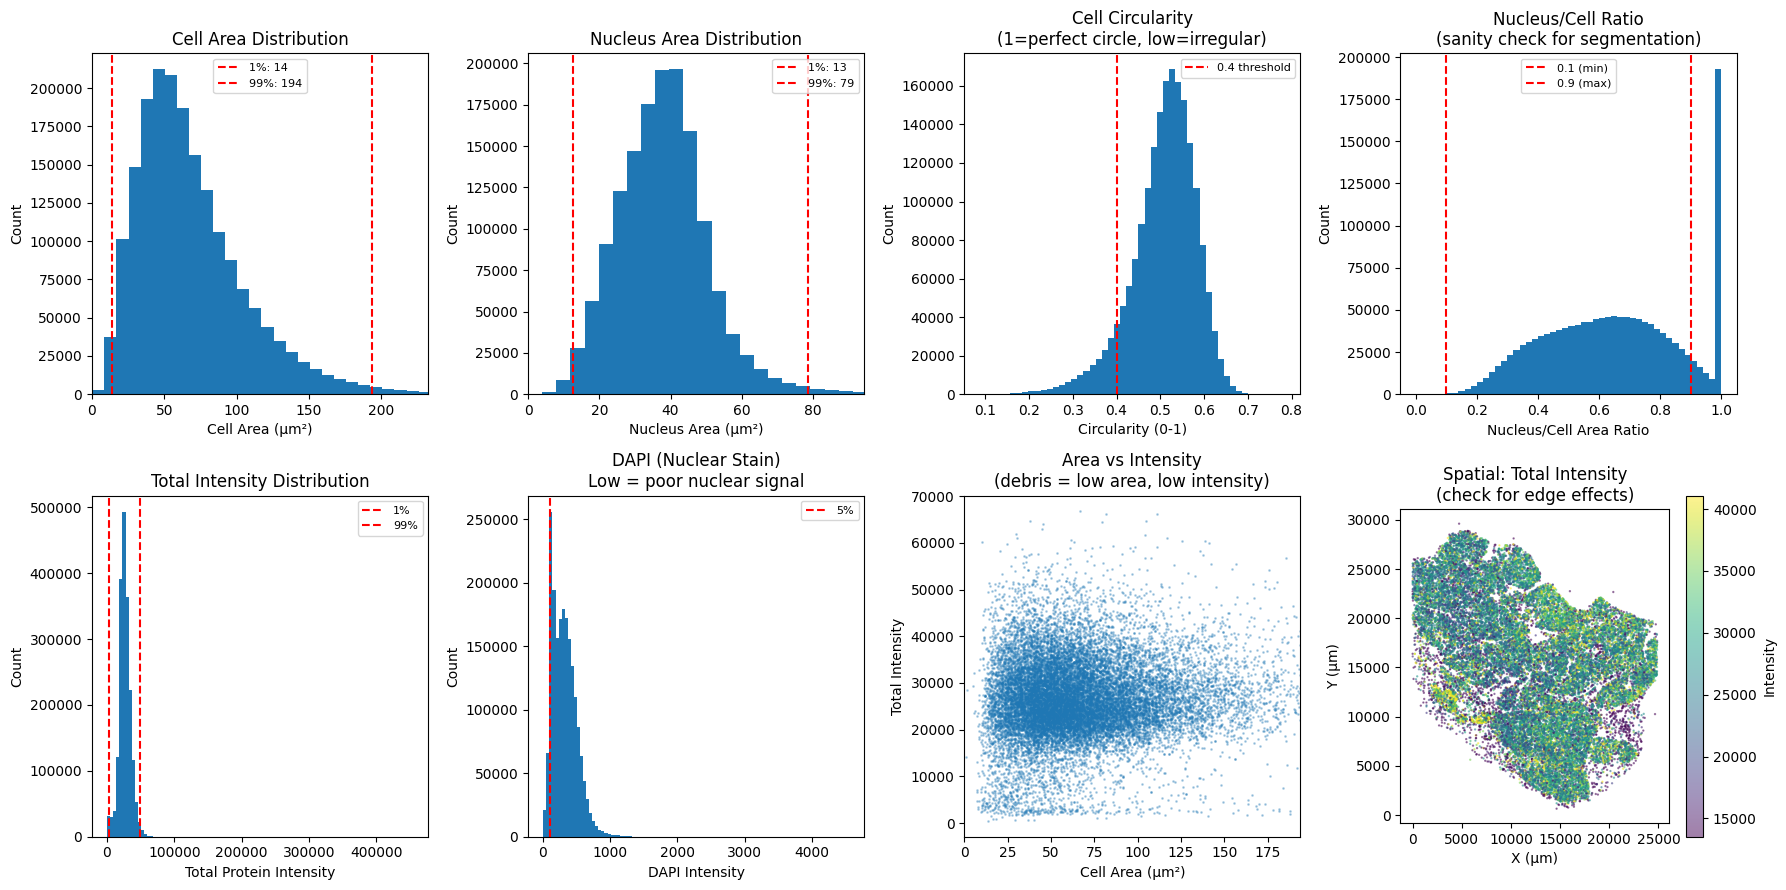


PROTEIN DATA QC SUMMARY
Total cells: 1,900,754

Suggested filters (adjust based on plots above):
  Cell Area: 14 - 194 µm²
  Circularity: > 0.3-0.4 (remove irregular shapes)
  Total Intensity: > 3311.6 (remove debris)


In [18]:
# Visualize protein/CODEX QC metrics for filtering
fig, axes = plt.subplots(2, 4, figsize=(18, 9))

# Row 1: Morphology distributions
# Cell Area
if 'Cell: Area µm^2' in codex_df.columns:
    area = codex_df['Cell: Area µm^2']
    axes[0, 0].hist(area, bins=100, edgecolor='none')
    axes[0, 0].set_xlabel('Cell Area (µm²)')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].set_title('Cell Area Distribution')
    axes[0, 0].axvline(x=area.quantile(0.01), color='r', linestyle='--', label=f'1%: {area.quantile(0.01):.0f}')
    axes[0, 0].axvline(x=area.quantile(0.99), color='r', linestyle='--', label=f'99%: {area.quantile(0.99):.0f}')
    axes[0, 0].legend(fontsize=8)
    axes[0, 0].set_xlim(0, area.quantile(0.99)*1.2)

# Nucleus Area
if 'Nucleus: Area µm^2' in codex_df.columns:
    nuc_area = codex_df['Nucleus: Area µm^2']
    axes[0, 1].hist(nuc_area, bins=100, edgecolor='none')
    axes[0, 1].set_xlabel('Nucleus Area (µm²)')
    axes[0, 1].set_ylabel('Count')
    axes[0, 1].set_title('Nucleus Area Distribution')
    axes[0, 1].axvline(x=nuc_area.quantile(0.01), color='r', linestyle='--', label=f'1%: {nuc_area.quantile(0.01):.0f}')
    axes[0, 1].axvline(x=nuc_area.quantile(0.99), color='r', linestyle='--', label=f'99%: {nuc_area.quantile(0.99):.0f}')
    axes[0, 1].legend(fontsize=8)
    axes[0, 1].set_xlim(0, nuc_area.quantile(0.99)*1.2)

# Circularity
if 'Cell: Circularity' in codex_df.columns:
    circ = codex_df['Cell: Circularity']
    axes[0, 2].hist(circ, bins=50, edgecolor='none')
    axes[0, 2].set_xlabel('Circularity (0-1)')
    axes[0, 2].set_ylabel('Count')
    axes[0, 2].set_title('Cell Circularity\n(1=perfect circle, low=irregular)')
    axes[0, 2].axvline(x=0.4, color='r', linestyle='--', label='0.4 threshold')
    axes[0, 2].legend(fontsize=8)

# Nucleus/Cell ratio
if 'Cell: Area µm^2' in codex_df.columns and 'Nucleus: Area µm^2' in codex_df.columns:
    nc_ratio = codex_df['Nucleus: Area µm^2'] / codex_df['Cell: Area µm^2']
    axes[0, 3].hist(nc_ratio, bins=50, edgecolor='none')
    axes[0, 3].set_xlabel('Nucleus/Cell Area Ratio')
    axes[0, 3].set_ylabel('Count')
    axes[0, 3].set_title('Nucleus/Cell Ratio\n(sanity check for segmentation)')
    axes[0, 3].axvline(x=0.1, color='r', linestyle='--', label='0.1 (min)')
    axes[0, 3].axvline(x=0.9, color='r', linestyle='--', label='0.9 (max)')
    axes[0, 3].legend(fontsize=8)

# Row 2: Intensity and spatial
# Total intensity (sum of all markers)
total_intensity = protein_matrix.sum(axis=1)
axes[1, 0].hist(total_intensity, bins=100, edgecolor='none')
axes[1, 0].set_xlabel('Total Protein Intensity')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Total Intensity Distribution')
axes[1, 0].axvline(x=np.percentile(total_intensity, 1), color='r', linestyle='--', label=f'1%')
axes[1, 0].axvline(x=np.percentile(total_intensity, 99), color='r', linestyle='--', label=f'99%')
axes[1, 0].legend(fontsize=8)

# DAPI intensity (nuclear stain - quality indicator)
if 'DAPI' in marker_names:
    dapi_idx = marker_names.index('DAPI')
    dapi = protein_matrix[:, dapi_idx]
    axes[1, 1].hist(dapi, bins=100, edgecolor='none')
    axes[1, 1].set_xlabel('DAPI Intensity')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('DAPI (Nuclear Stain)\nLow = poor nuclear signal')
    axes[1, 1].axvline(x=np.percentile(dapi, 5), color='r', linestyle='--', label='5%')
    axes[1, 1].legend(fontsize=8)
else:
    axes[1, 1].text(0.5, 0.5, 'DAPI not found', ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('DAPI Intensity')

# Cell area vs total intensity (reveals debris vs cells)
if 'Cell: Area µm^2' in codex_df.columns:
    sample_idx = np.random.choice(len(codex_df), min(20000, len(codex_df)), replace=False)
    axes[1, 2].scatter(codex_df['Cell: Area µm^2'].values[sample_idx], 
                       total_intensity[sample_idx], s=1, alpha=0.3)
    axes[1, 2].set_xlabel('Cell Area (µm²)')
    axes[1, 2].set_ylabel('Total Intensity')
    axes[1, 2].set_title('Area vs Intensity\n(debris = low area, low intensity)')
    axes[1, 2].set_xlim(0, codex_df['Cell: Area µm^2'].quantile(0.99))

# Spatial distribution colored by total intensity
sample_idx = np.random.choice(len(codex_df), min(30000, len(codex_df)), replace=False)
scatter = axes[1, 3].scatter(x_coords[sample_idx], y_coords[sample_idx], 
                              c=total_intensity[sample_idx], s=0.5, alpha=0.5,
                              cmap='viridis', vmin=np.percentile(total_intensity, 5),
                              vmax=np.percentile(total_intensity, 95))
axes[1, 3].set_xlabel('X (µm)')
axes[1, 3].set_ylabel('Y (µm)')
axes[1, 3].set_title('Spatial: Total Intensity\n(check for edge effects)')
axes[1, 3].set_aspect('equal')
plt.colorbar(scatter, ax=axes[1, 3], label='Intensity')

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*60)
print("PROTEIN DATA QC SUMMARY")
print("="*60)
print(f"Total cells: {len(codex_df):,}")
print(f"\nSuggested filters (adjust based on plots above):")
if 'Cell: Area µm^2' in codex_df.columns:
    print(f"  Cell Area: {area.quantile(0.01):.0f} - {area.quantile(0.99):.0f} µm²")
if 'Cell: Circularity' in codex_df.columns:
    print(f"  Circularity: > 0.3-0.4 (remove irregular shapes)")
print(f"  Total Intensity: > {np.percentile(total_intensity, 1):.1f} (remove debris)")

In [ ]:
# Apply protein/CODEX filtering
# Adjust these thresholds based on the diagnostic plots above

# Morphology filters
# MIN_CELL_AREA = 10       # µm² - remove debris/fragments
# MAX_CELL_AREA = 100      # µm² - remove merged cells/clumps
# MIN_CIRCULARITY = 0.3    # Remove very irregular shapes (segmentation errors)

# # Intensity filters  
# MIN_TOTAL_INTENSITY = 00  # Remove very dim cells (debris, out of focus)


# print("Protein filtering criteria:")
# print(f"  Cell Area: {MIN_CELL_AREA} - {MAX_CELL_AREA} µm²")
# print(f"  Min Circularity: {MIN_CIRCULARITY}")
# print(f"  Min Total Intensity: {MIN_TOTAL_INTENSITY}")

# # Build filter mask
# protein_mask = np.ones(len(codex_df), dtype=bool)

# if 'Cell: Area µm^2' in codex_df.columns:
#     area = codex_df['Cell: Area µm^2'].values
#     protein_mask &= (area >= MIN_CELL_AREA) & (area <= MAX_CELL_AREA)
#     print(f"\nAfter area filter: {protein_mask.sum():,} cells")

# if 'Cell: Circularity' in codex_df.columns:
#     circ = codex_df['Cell: Circularity'].values
#     protein_mask &= (circ >= MIN_CIRCULARITY)
#     print(f"After circularity filter: {protein_mask.sum():,} cells")

# total_intensity = protein_matrix.sum(axis=1)
# protein_mask &= (total_intensity >= MIN_TOTAL_INTENSITY)
# print(f"After intensity filter: {protein_mask.sum():,} cells")

# print(f"\nFiltered: {len(codex_df):,} → {protein_mask.sum():,} cells ({100*protein_mask.sum()/len(codex_df):.1f}% retained)")

# # Apply filter to all protein data
# codex_df_filtered = codex_df[protein_mask].reset_index(drop=True)
# protein_matrix_filtered = protein_matrix[protein_mask]
# x_coords_filtered = x_coords[protein_mask]
# y_coords_filtered = y_coords[protein_mask]

# # Update variables for downstream use
# codex_df = codex_df_filtered
# protein_matrix = protein_matrix_filtered
# x_coords = x_coords_filtered
# y_coords = y_coords_filtered

# # IMPORTANT: Recreate protein_adata with filtered data
# protein_adata = ad.AnnData(protein_matrix.astype(np.float32))
# protein_adata.var_names = marker_names
# protein_adata.obs['X_centroid'] = x_coords
# protein_adata.obs['Y_centroid'] = y_coords
# protein_adata.obs_names = [f"cell_{i}" for i in range(protein_adata.n_obs)]

# print(f"\nProtein data updated: {protein_matrix.shape}")
# print(f"protein_adata recreated: {protein_adata.shape}")


## Step 2: Load and Filter RNA-seq Data

We use **raw unfiltered** 10x data to ensure proper cell calling.
This avoids issues from pre-filtered data that may have been processed differently.

In [2]:
# Load RAW RNA data (unfiltered - includes empty droplets)
print("Loading RAW RNA matrix (this may take a moment)...")
rna_mtx = mmread("data/raw_feature_bc_matrix/matrix.mtx.gz")
rna_names = pd.read_csv('data/raw_feature_bc_matrix/features.tsv.gz', sep='\t', header=None)[1].to_numpy()
rna_barcodes = pd.read_csv('data/raw_feature_bc_matrix/barcodes.tsv.gz', header=None)[0].values

rna_adata = ad.AnnData(rna_mtx.T.tocsr(), dtype=np.float32)
rna_adata.var_names = rna_names
rna_adata.var_names_make_unique()
rna_adata.obs_names = rna_barcodes

print(f"RNA raw (unfiltered): {rna_adata.shape}")
print(f"  This includes empty droplets - will filter next")

Loading RAW RNA matrix (this may take a moment)...
RNA raw (unfiltered): (371575, 33538)
  This includes empty droplets - will filter next


In [3]:
# Calculate QC metrics for cell filtering
print("Calculating QC metrics...")

# Basic QC metrics
rna_adata.var['mt'] = rna_adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(rna_adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

print(f"\nQC metric ranges (before filtering):")
print(f"  Total counts: {rna_adata.obs['total_counts'].min():.0f} - {rna_adata.obs['total_counts'].max():.0f}")
print(f"  Genes detected: {rna_adata.obs['n_genes_by_counts'].min():.0f} - {rna_adata.obs['n_genes_by_counts'].max():.0f}")
print(f"  MT %: {rna_adata.obs['pct_counts_mt'].min():.1f} - {rna_adata.obs['pct_counts_mt'].max():.1f}")

Calculating QC metrics...

QC metric ranges (before filtering):
  Total counts: 0 - 111262
  Genes detected: 0 - 8032
  MT %: 0.0 - 100.0


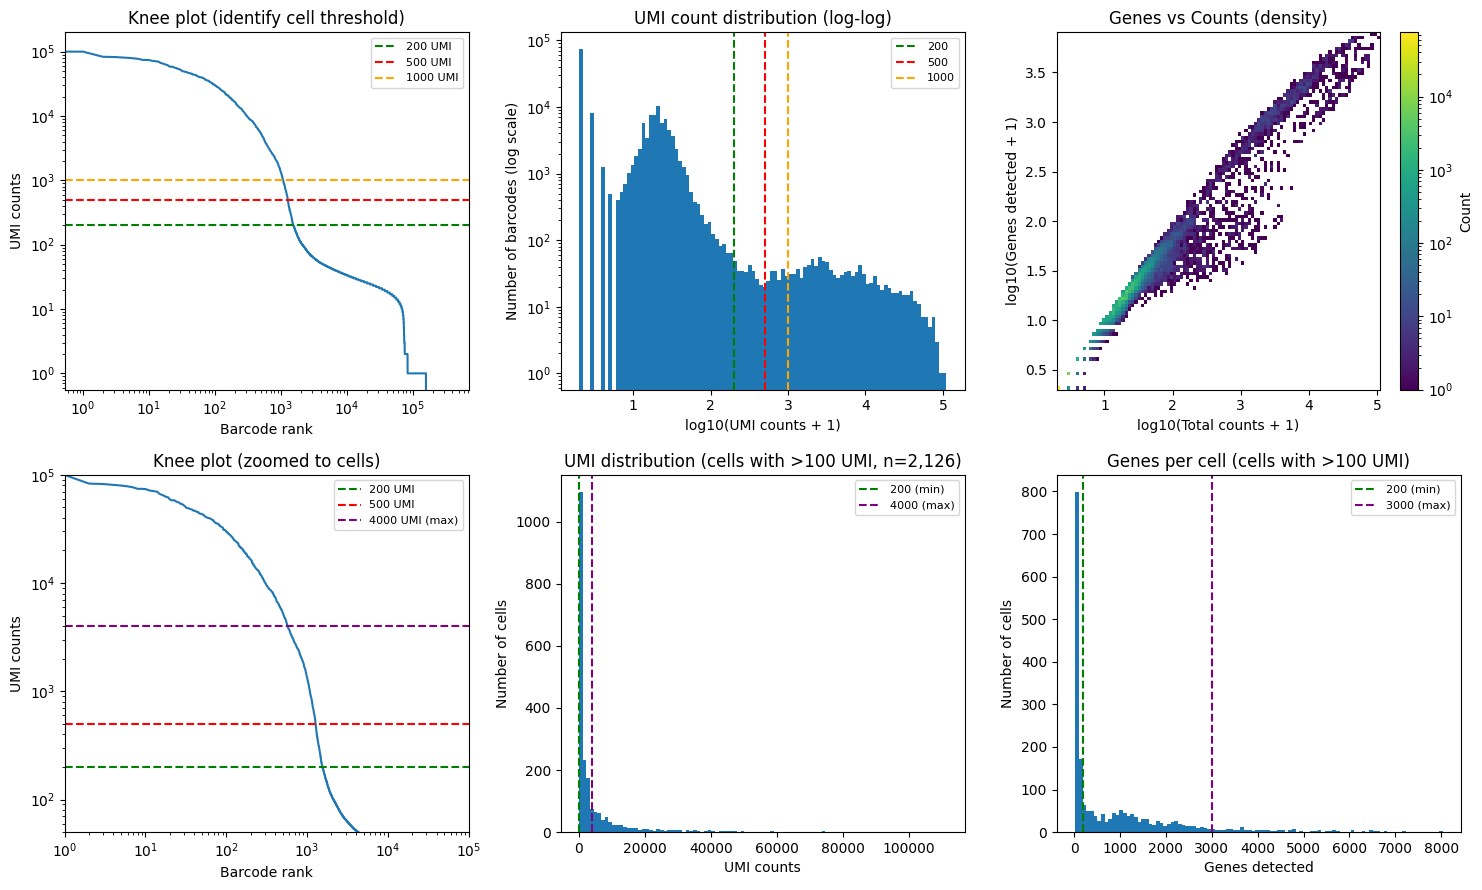


Cell counts at different UMI thresholds:
  >=  100 UMI: 2,126 cells
  >=  200 UMI: 1,548 cells
  >=  300 UMI: 1,414 cells
  >=  500 UMI: 1,273 cells
  >= 1000 UMI: 1,084 cells
  >= 2000 UMI: 858 cells
  >= 4000 UMI: 571 cells


In [4]:
# Visualize count distribution to identify cell calling threshold
fig, axes = plt.subplots(2, 3, figsize=(15, 9))

# Row 1: Full data view
# Knee plot - sorted UMI counts
counts_sorted = np.sort(rna_adata.obs['total_counts'].values)[::-1]
axes[0, 0].plot(np.arange(len(counts_sorted)), counts_sorted)
axes[0, 0].set_xscale('log')
axes[0, 0].set_yscale('log')
axes[0, 0].set_xlabel('Barcode rank')
axes[0, 0].set_ylabel('UMI counts')
axes[0, 0].set_title('Knee plot (identify cell threshold)')
axes[0, 0].axhline(y=200, color='g', linestyle='--', label='200 UMI')
axes[0, 0].axhline(y=500, color='r', linestyle='--', label='500 UMI')
axes[0, 0].axhline(y=1000, color='orange', linestyle='--', label='1000 UMI')
axes[0, 0].legend(fontsize=8)

# Histogram of counts - LOG Y-AXIS to see cell population
counts_nonzero = rna_adata.obs['total_counts'][rna_adata.obs['total_counts'] > 0]
axes[0, 1].hist(np.log10(counts_nonzero + 1), bins=100)
axes[0, 1].set_yscale('log')  # Log y-axis to see the cell population
axes[0, 1].set_xlabel('log10(UMI counts + 1)')
axes[0, 1].set_ylabel('Number of barcodes (log scale)')
axes[0, 1].set_title('UMI count distribution (log-log)')
axes[0, 1].axvline(x=np.log10(200), color='g', linestyle='--', label='200')
axes[0, 1].axvline(x=np.log10(500), color='r', linestyle='--', label='500')
axes[0, 1].axvline(x=np.log10(1000), color='orange', linestyle='--', label='1000')
axes[0, 1].legend(fontsize=8)

# Genes vs counts - use 2D histogram for density
mask = rna_adata.obs['total_counts'] > 0
x_data = np.log10(rna_adata.obs['total_counts'].values[mask] + 1)
y_data = np.log10(rna_adata.obs['n_genes_by_counts'].values[mask] + 1)
h = axes[0, 2].hist2d(x_data, y_data, bins=100, cmap='viridis', norm='log')
axes[0, 2].set_xlabel('log10(Total counts + 1)')
axes[0, 2].set_ylabel('log10(Genes detected + 1)')
axes[0, 2].set_title('Genes vs Counts (density)')
plt.colorbar(h[3], ax=axes[0, 2], label='Count')

# Row 2: Zoomed to cell population (counts > 100)
cell_mask = rna_adata.obs['total_counts'] >= 100

# Zoomed knee plot
axes[1, 0].plot(np.arange(len(counts_sorted)), counts_sorted)
axes[1, 0].set_xscale('log')
axes[1, 0].set_xlim(1, 1e5)
axes[1, 0].set_ylim(50, 1e5)
axes[1, 0].set_yscale('log')
axes[1, 0].set_xlabel('Barcode rank')
axes[1, 0].set_ylabel('UMI counts')
axes[1, 0].set_title('Knee plot (zoomed to cells)')
axes[1, 0].axhline(y=200, color='g', linestyle='--', label='200 UMI')
axes[1, 0].axhline(y=500, color='r', linestyle='--', label='500 UMI')
axes[1, 0].axhline(y=4000, color='purple', linestyle='--', label='4000 UMI (max)')
axes[1, 0].legend(fontsize=8)

# Histogram zoomed to cells only
cell_counts = rna_adata.obs['total_counts'][cell_mask]
axes[1, 1].hist(cell_counts, bins=100)
axes[1, 1].set_xlabel('UMI counts')
axes[1, 1].set_ylabel('Number of cells')
axes[1, 1].set_title(f'UMI distribution (cells with >100 UMI, n={cell_mask.sum():,})')
axes[1, 1].axvline(x=200, color='g', linestyle='--', label='200 (min)')
axes[1, 1].axvline(x=4000, color='purple', linestyle='--', label='4000 (max)')
axes[1, 1].legend(fontsize=8)

# Genes histogram zoomed to cells
cell_genes = rna_adata.obs['n_genes_by_counts'][cell_mask]
axes[1, 2].hist(cell_genes, bins=100)
axes[1, 2].set_xlabel('Genes detected')
axes[1, 2].set_ylabel('Number of cells')
axes[1, 2].set_title(f'Genes per cell (cells with >100 UMI)')
axes[1, 2].axvline(x=200, color='g', linestyle='--', label='200 (min)')
axes[1, 2].axvline(x=3000, color='purple', linestyle='--', label='3000 (max)')
axes[1, 2].legend(fontsize=8)

plt.tight_layout()
plt.show()

# Count cells at different thresholds
print("\nCell counts at different UMI thresholds:")
for thresh in [100, 200, 300, 500, 1000, 2000, 4000]:
    n_cells = (rna_adata.obs['total_counts'] >= thresh).sum()
    print(f"  >= {thresh:4d} UMI: {n_cells:,} cells")

In [5]:
# Interactive QC Dashboard with Linked Threshold Sliders
# Adjust sliders to see thresholds update across all plots simultaneously

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import ipywidgets as widgets
from IPython.display import display, clear_output
import numpy as np

# Auto-detect environment and set appropriate renderer
def get_renderer():
    try:
        from IPython import get_ipython
        shell = get_ipython().__class__.__name__
        if 'ZMQInteractiveShell' in shell:
            # Check for VS Code
            import os
            if 'VSCODE' in os.environ.get('TERM_PROGRAM', ''):
                return 'vscode'
            return 'notebook'
    except:
        pass
    return 'browser'

pio.renderers.default = get_renderer()

# Prepare data - handle NaN values
obs = rna_adata.obs
total_counts = obs['total_counts'].values
n_genes = obs['n_genes_by_counts'].values
pct_mt = obs['pct_counts_mt'].values

# Create mask for valid data (no NaNs, meets minimum count threshold)
valid_mask = (
    ~np.isnan(total_counts) & 
    ~np.isnan(n_genes) & 
    ~np.isnan(pct_mt) &
    (total_counts >= 100)
)

print(f"Total barcodes: {len(obs):,}")
print(f"Valid cells (no NaN, >= 100 UMI): {valid_mask.sum():,}")
print(f"Excluded (NaN or low UMI): {(~valid_mask).sum():,}")

# Get data ranges from valid data
umi_data_min = int(np.floor(total_counts[valid_mask].min()))
umi_data_max = int(np.ceil(total_counts[valid_mask].max()))
genes_data_min = int(np.floor(n_genes[valid_mask].min()))
genes_data_max = int(np.ceil(n_genes[valid_mask].max()))
mt_data_min = 0
mt_data_max = float(np.ceil(pct_mt[valid_mask].max()))

print(f"\nData ranges:")
print(f"  UMI: {umi_data_min:,} - {umi_data_max:,}")
print(f"  Genes: {genes_data_min:,} - {genes_data_max:,}")
print(f"  MT%: {mt_data_min:.1f} - {mt_data_max:.1f}")

# Subsample for performance if needed
n_points = min(50000, valid_mask.sum())
if valid_mask.sum() > n_points:
    valid_indices = np.where(valid_mask)[0]
    subsample_idx = np.random.choice(valid_indices, n_points, replace=False)
    scatter_mask = np.zeros(len(obs), dtype=bool)
    scatter_mask[subsample_idx] = True
else:
    scatter_mask = valid_mask

# Initial threshold values
init_mt = mt_data_max
init_min_umi = umi_data_min
init_max_umi = umi_data_max
init_min_genes = genes_data_min
init_max_genes = genes_data_max

# Pre-compute histograms
mt_valid = pct_mt[valid_mask]
mt_hist = np.histogram(mt_valid, bins=100)
umi_valid = total_counts[valid_mask]
umi_hist_max = min(umi_data_max, 20000)
umi_hist = np.histogram(umi_valid[umi_valid <= umi_hist_max], bins=100, range=(0, umi_hist_max))
genes_valid = n_genes[valid_mask]
genes_hist = np.histogram(genes_valid, bins=100)

# Pre-extract scatter data
scatter_x = total_counts[scatter_mask]
scatter_y_mt = pct_mt[scatter_mask]
scatter_y_genes = n_genes[scatter_mask]

def create_figure(mt_max, min_umi, max_umi, min_genes, max_genes):
    """Create the QC dashboard figure with current threshold values."""
    fig = make_subplots(
        rows=2, cols=3,
        subplot_titles=(
            'MT% Distribution', 
            'MT% vs UMI Counts',
            'Genes vs Counts (colored by MT%)',
            'UMI Distribution',
            'Genes Distribution',
            'Cells Passing Filters'
        ),
        specs=[[{}, {}, {}], [{}, {}, {"type": "domain"}]],
        vertical_spacing=0.15,
        horizontal_spacing=0.08
    )
    
    # 1. MT% histogram
    fig.add_trace(go.Bar(x=mt_hist[1][:-1], y=mt_hist[0], 
                         marker_color='steelblue', showlegend=False), row=1, col=1)
    
    # 2. MT% vs UMI scatter
    fig.add_trace(go.Scattergl(
        x=scatter_x, y=scatter_y_mt,
        mode='markers',
        marker=dict(size=2, opacity=0.3, color='steelblue'),
        showlegend=False,
        hovertemplate='UMI: %{x}<br>MT%%: %{y:.1f}<extra></extra>'
    ), row=1, col=2)
    
    # 3. Genes vs Counts colored by MT%
    fig.add_trace(go.Scattergl(
        x=scatter_x, y=scatter_y_genes,
        mode='markers',
        marker=dict(
            size=2, opacity=0.5,
            color=scatter_y_mt,
            colorscale='RdYlBu_r',
            cmin=0, cmax=30,
            colorbar=dict(title='MT%', x=1.02, len=0.4, y=0.8)
        ),
        showlegend=False,
        hovertemplate='UMI: %{x}<br>Genes: %{y}<br>MT%%: %{marker.color:.1f}<extra></extra>'
    ), row=1, col=3)
    
    # 4. UMI histogram
    fig.add_trace(go.Bar(x=umi_hist[1][:-1], y=umi_hist[0], 
                         marker_color='steelblue', showlegend=False), row=2, col=1)
    
    # 5. Genes histogram
    fig.add_trace(go.Bar(x=genes_hist[1][:-1], y=genes_hist[0], 
                         marker_color='steelblue', showlegend=False), row=2, col=2)
    
    # 6. Calculate passing cells and add pie chart
    mask = (
        valid_mask &
        (total_counts >= min_umi) &
        (total_counts <= max_umi) &
        (n_genes >= min_genes) &
        (n_genes <= max_genes) &
        (pct_mt <= mt_max)
    )
    n_pass = mask.sum()
    n_fail = valid_mask.sum() - n_pass
    
    fig.add_trace(go.Pie(
        values=[n_pass, n_fail],
        labels=['Pass', 'Fail'],
        marker_colors=['#90EE90', '#FFB6C1'],
        hole=0.4,
        showlegend=False,
        textinfo='percent+label'
    ), row=2, col=3)
    
    # Add threshold lines
    shapes = []
    # MT lines
    shapes.append(dict(type='line', x0=mt_max, x1=mt_max, y0=0, y1=1, yref='y domain',
                       xref='x', line=dict(color='red', dash='dash', width=2)))
    shapes.append(dict(type='line', x0=0, x1=1, xref='x2 domain', y0=mt_max, y1=mt_max,
                       yref='y2', line=dict(color='red', dash='dash', width=2)))
    # Min UMI lines
    for xref, yref in [('x2', 'y2 domain'), ('x3', 'y3 domain'), ('x4', 'y4 domain')]:
        shapes.append(dict(type='line', x0=min_umi, x1=min_umi, y0=0, y1=1, 
                           yref=yref, xref=xref, line=dict(color='green', dash='dash', width=2)))
    # Max UMI lines
    for xref, yref in [('x2', 'y2 domain'), ('x3', 'y3 domain'), ('x4', 'y4 domain')]:
        shapes.append(dict(type='line', x0=max_umi, x1=max_umi, y0=0, y1=1, 
                           yref=yref, xref=xref, line=dict(color='orange', dash='dash', width=2)))
    # Min genes lines
    shapes.append(dict(type='line', x0=0, x1=1, xref='x3 domain', y0=min_genes, y1=min_genes,
                       yref='y3', line=dict(color='purple', dash='dash', width=2)))
    shapes.append(dict(type='line', x0=min_genes, x1=min_genes, y0=0, y1=1, yref='y5 domain',
                       xref='x5', line=dict(color='purple', dash='dash', width=2)))
    # Max genes lines
    shapes.append(dict(type='line', x0=0, x1=1, xref='x3 domain', y0=max_genes, y1=max_genes,
                       yref='y3', line=dict(color='saddlebrown', dash='dash', width=2)))
    shapes.append(dict(type='line', x0=max_genes, x1=max_genes, y0=0, y1=1, yref='y5 domain',
                       xref='x5', line=dict(color='saddlebrown', dash='dash', width=2)))
    
    fig.update_layout(shapes=shapes)
    
    # Update axes
    fig.update_xaxes(type='log', row=1, col=2, title_text='UMI Counts')
    fig.update_xaxes(type='log', row=1, col=3, title_text='UMI Counts')
    fig.update_yaxes(type='log', row=1, col=3, title_text='Genes')
    fig.update_xaxes(range=[0, umi_hist_max], row=2, col=1, title_text='UMI Counts')
    fig.update_xaxes(title_text='MT%', row=1, col=1)
    fig.update_xaxes(title_text='Genes', row=2, col=2)
    fig.update_yaxes(title_text='MT%', row=1, col=2)
    
    fig.update_layout(
        height=1000,
        width=1500,
        title_text='Interactive QC Dashboard - Drag sliders to adjust thresholds',
        title_x=0.5
    )
    
    return fig, n_pass

# Create sliders
mt_slider = widgets.FloatSlider(value=init_mt, min=0, max=mt_data_max, step=0.5, 
                                 description='Max MT%:', readout_format='.1f',
                                 style={'description_width': '80px'}, 
                                 layout=widgets.Layout(width='350px'))
min_umi_slider = widgets.IntSlider(value=init_min_umi, min=umi_data_min, max=umi_data_max//2, step=50, 
                                    description='Min UMI:',
                                    style={'description_width': '80px'}, 
                                    layout=widgets.Layout(width='350px'))
max_umi_slider = widgets.IntSlider(value=init_max_umi, min=umi_data_max//2, max=umi_data_max, step=100, 
                                    description='Max UMI:',
                                    style={'description_width': '80px'}, 
                                    layout=widgets.Layout(width='350px'))
min_genes_slider = widgets.IntSlider(value=init_min_genes, min=genes_data_min, max=genes_data_max//2, step=25, 
                                      description='Min Genes:',
                                      style={'description_width': '80px'}, 
                                      layout=widgets.Layout(width='350px'))
max_genes_slider = widgets.IntSlider(value=init_max_genes, min=genes_data_max//2, max=genes_data_max, step=50, 
                                      description='Max Genes:',
                                      style={'description_width': '80px'}, 
                                      layout=widgets.Layout(width='350px'))

# Output widget for the figure
fig_output = widgets.Output()
cell_count_output = widgets.HTML(value='')

def update_dashboard(change=None):
    """Update the dashboard when sliders change."""
    mt_max = mt_slider.value
    min_umi = min_umi_slider.value
    max_umi = max_umi_slider.value
    min_genes = min_genes_slider.value
    max_genes = max_genes_slider.value
    
    fig, n_pass = create_figure(mt_max, min_umi, max_umi, min_genes, max_genes)
    pct = 100 * n_pass / valid_mask.sum()
    
    # Update cell count display
    cell_count_output.value = f"""
    <div style="font-size: 14px; padding: 10px; background: linear-gradient(to right, #90EE90 {pct}%, #FFB6C1 {pct}%); 
                border-radius: 5px; text-align: center;">
        <b>Cells passing:</b> {n_pass:,} / {valid_mask.sum():,} ({pct:.1f}%)
    </div>
    """
    
    # Update figure
    with fig_output:
        clear_output(wait=True)
        fig.show()

# Connect sliders
for slider in [mt_slider, min_umi_slider, max_umi_slider, min_genes_slider, max_genes_slider]:
    slider.observe(update_dashboard, names='value')

# Layout
slider_box = widgets.VBox([
    widgets.HTML('<h4 style="margin:5px 0">Filter Thresholds</h4>'),
    widgets.HBox([min_umi_slider, max_umi_slider]),
    widgets.HBox([min_genes_slider, max_genes_slider]),
    widgets.HBox([mt_slider]),
    cell_count_output
], layout=widgets.Layout(padding='10px', border='1px solid #ddd', border_radius='5px'))

# Display
display(slider_box)
display(fig_output)

# Initial render
update_dashboard()

print("""
Threshold Legend:
  - Red (dashed): Max MT%
  - Green (dashed): Min UMI
  - Orange (dashed): Max UMI  
  - Purple (dashed): Min Genes
  - Brown (dashed): Max Genes
""")

Total barcodes: 371,575
Valid cells (no NaN, >= 100 UMI): 2,126
Excluded (NaN or low UMI): 369,449

Data ranges:
  UMI: 100 - 111,262
  Genes: 21 - 8,032
  MT%: 0.0 - 98.0


Output()


Threshold Legend:
  - Red (dashed): Max MT%
  - Green (dashed): Min UMI
  - Orange (dashed): Max UMI  
  - Purple (dashed): Min Genes
  - Brown (dashed): Max Genes



In [6]:
# Apply cell filtering
# Based on knee plot analysis - using both min and max filters to remove:
# - Empty droplets / low-quality cells (min filters)
# - Doublets / multiplets (max filters)

MIN_COUNTS = 100      # Minimum UMI counts per cell
MAX_COUNTS = 92731    # Maximum UMI counts (remove doublets)
MIN_GENES = 46       # Minimum genes detected per cell  
MAX_GENES = 7066     # Maximum genes detected (remove doublets)
MAX_MT_PCT = 39.5       # Maximum mitochondrial percentage

print(f"Filtering criteria:")
print(f"  Min UMI counts: {MIN_COUNTS}")
print(f"  Max UMI counts: {MAX_COUNTS}")
print(f"  Min genes: {MIN_GENES}")
print(f"  Max genes: {MAX_GENES}")
print(f"  Max MT%: {MAX_MT_PCT}")

# Save pre-filter data for comparison plot
prefilter_counts = rna_adata.obs['total_counts'].values.copy()
prefilter_genes = rna_adata.obs['n_genes_by_counts'].values.copy()
prefilter_mt = rna_adata.obs['pct_counts_mt'].values.copy()
prefilter_n = rna_adata.n_obs

# Apply filters
print(f"\nBefore filtering: {rna_adata.n_obs:,} barcodes")

# Min filters
sc.pp.filter_cells(rna_adata, min_counts=MIN_COUNTS)
print(f"After min_counts filter: {rna_adata.n_obs:,} cells")

sc.pp.filter_cells(rna_adata, min_genes=MIN_GENES)
print(f"After min_genes filter: {rna_adata.n_obs:,} cells")

# Max filters (remove doublets)
rna_adata = rna_adata[rna_adata.obs['total_counts'] < MAX_COUNTS, :].copy()
print(f"After max_counts filter: {rna_adata.n_obs:,} cells")

rna_adata = rna_adata[rna_adata.obs['n_genes_by_counts'] < MAX_GENES, :].copy()
print(f"After max_genes filter: {rna_adata.n_obs:,} cells")

# MT filter
rna_adata = rna_adata[rna_adata.obs['pct_counts_mt'] < MAX_MT_PCT, :].copy()
print(f"After MT filter: {rna_adata.n_obs:,} cells")

# =============================================================================
# MARKER-PRESERVING GENE FILTER
# Standard min_cells=3 filter, but ALWAYS keep genes corresponding to protein markers
# This ensures integration has maximum shared features even for sparse markers
# =============================================================================

# Load protein-gene conversion table to identify marker genes
conversion_df = pd.read_csv('data/protein_gene_conversion.csv', encoding='utf-8-sig')

# Extract all gene names from conversion table (handling multiple options separated by /)
protected_genes = set()
for rna_name in conversion_df['RNA name']:
    if pd.isna(rna_name) or str(rna_name).startswith('Ignore'):
        continue
    for gene in str(rna_name).split('/'):
        gene = gene.strip()
        if gene:
            protected_genes.add(gene)

print(f"\nMarker-preserving gene filter:")
print(f"  Protected marker genes from conversion table: {len(protected_genes)}")

# Find which protected genes exist in our data
protected_in_data = protected_genes & set(rna_adata.var_names)
print(f"  Protected genes found in RNA data: {len(protected_in_data)}")

# Calculate cells per gene
n_cells_per_gene = np.array((rna_adata.X > 0).sum(axis=0)).flatten()

# Standard filter mask: genes in >= 3 cells
standard_keep = n_cells_per_gene >= 3

# Protected gene mask: always keep these genes
protected_mask = np.array([g in protected_in_data for g in rna_adata.var_names])

# Combined filter: keep if (standard filter passes) OR (is protected marker)
combined_keep = standard_keep | protected_mask

# Identify rescued genes (would be filtered but are protected)
rescued_mask = protected_mask & ~standard_keep
n_rescued = rescued_mask.sum()
rescued_gene_names = [g for g, r in zip(rna_adata.var_names, rescued_mask) if r]

print(f"  Marker genes rescued (would be filtered, now kept): {n_rescued}")
if rescued_gene_names:
    print(f"  Rescued genes: {rescued_gene_names}")

# Apply the filter
rna_adata = rna_adata[:, combined_keep].copy()
print(f"After marker-preserving gene filter: {rna_adata.n_vars:,} genes")

print(f"\nFinal RNA data: {rna_adata.shape}")

Filtering criteria:
  Min UMI counts: 100
  Max UMI counts: 92731
  Min genes: 46
  Max genes: 7066
  Max MT%: 39.5

Before filtering: 371,575 barcodes
After min_counts filter: 2,126 cells
After min_genes filter: 1,935 cells
After max_counts filter: 1,933 cells
After max_genes filter: 1,928 cells
After MT filter: 1,669 cells

Marker-preserving gene filter:
  Protected marker genes from conversion table: 289
  Protected genes found in RNA data: 280
  Marker genes rescued (would be filtered, now kept): 54
  Rescued genes: ['MPL', 'CD160', 'FCRL5', 'FCRL4', 'CD1A', 'CD1C', 'FCER1A', 'ITLN1', 'SELP', 'CD207', 'GCG', 'CCR4', 'CCR9', 'XCR1', 'CCR3', 'CCR2', 'BTLA', 'SOX2', 'SST', 'TP63', 'GYPB', 'GYPA', 'TIMD4', 'FLT4', 'NCR2', 'CCR6', 'FOXP3', 'CD40LG', 'L1CAM', 'DEFA5', 'MUC2', 'CD44-AS1', 'MS4A1', 'PTGDR2', 'CLEC4C', 'CLEC1B', 'CLEC9A', 'IAPP', 'IGHD', 'TNFRSF17', 'CD19', 'GP1BA', 'TNFRSF13B', 'LGALS9C', 'LGALS9B', 'NOS2', 'ITGA2B', 'MPO', 'CDH2', 'CEACAM5', 'CEACAM8', 'CD177', 'SIGLEC8',

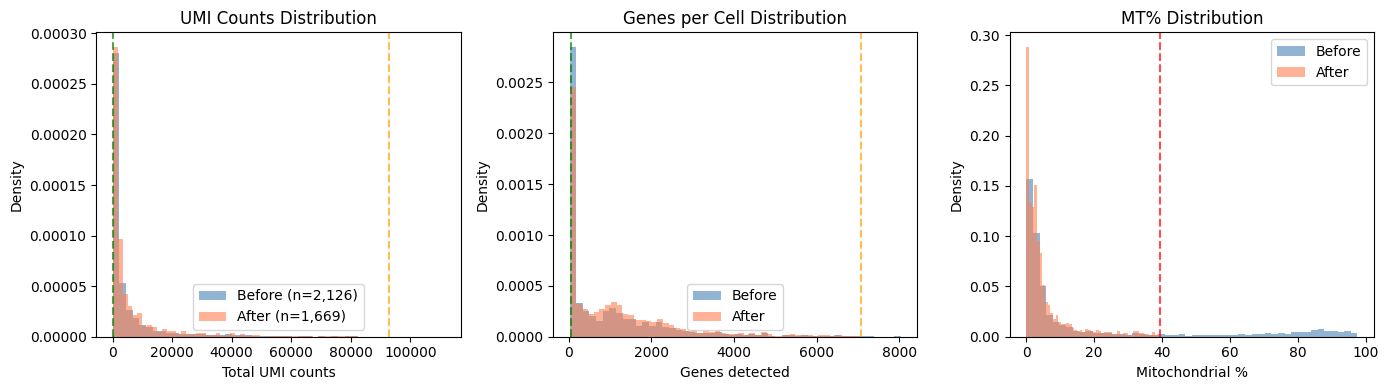


Metric                             Before           After          Change
Number of cells                     2,126           1,669            -457
Median UMI/cell                     1,064           2,006
Median genes/cell                     308             791
Median MT%                            3.8             2.8
Cells retained                                      78.5%


In [7]:
# Visualize QC: Before vs After filtering (overlaid distributions)
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# Filter prefilter data to valid range for fair comparison (same as interactive plot)
prefilter_valid = (
    ~np.isnan(prefilter_counts) & 
    ~np.isnan(prefilter_genes) & 
    ~np.isnan(prefilter_mt) &
    (prefilter_counts >= 100)
)

# Colors
before_color = 'steelblue'
after_color = 'coral'
alpha = 0.6

# Plot 1: UMI counts
axes[0].hist(prefilter_counts[prefilter_valid], bins=50, alpha=alpha, color=before_color, 
             label=f'Before (n={prefilter_valid.sum():,})', density=True)
axes[0].hist(rna_adata.obs['total_counts'], bins=50, alpha=alpha, color=after_color,
             label=f'After (n={rna_adata.n_obs:,})', density=True)
axes[0].set_xlabel('Total UMI counts')
axes[0].set_ylabel('Density')
axes[0].set_title('UMI Counts Distribution')
axes[0].legend()
axes[0].axvline(x=MIN_COUNTS, color='green', linestyle='--', alpha=0.7, label=f'Min: {MIN_COUNTS}')
axes[0].axvline(x=MAX_COUNTS, color='orange', linestyle='--', alpha=0.7, label=f'Max: {MAX_COUNTS}')

# Plot 2: Genes detected
axes[1].hist(prefilter_genes[prefilter_valid], bins=50, alpha=alpha, color=before_color,
             label='Before', density=True)
axes[1].hist(rna_adata.obs['n_genes_by_counts'], bins=50, alpha=alpha, color=after_color,
             label='After', density=True)
axes[1].set_xlabel('Genes detected')
axes[1].set_ylabel('Density')
axes[1].set_title('Genes per Cell Distribution')
axes[1].legend()
axes[1].axvline(x=MIN_GENES, color='green', linestyle='--', alpha=0.7)
axes[1].axvline(x=MAX_GENES, color='orange', linestyle='--', alpha=0.7)

# Plot 3: MT%
axes[2].hist(prefilter_mt[prefilter_valid], bins=50, alpha=alpha, color=before_color,
             label='Before', density=True)
axes[2].hist(rna_adata.obs['pct_counts_mt'], bins=50, alpha=alpha, color=after_color,
             label='After', density=True)
axes[2].set_xlabel('Mitochondrial %')
axes[2].set_ylabel('Density')
axes[2].set_title('MT% Distribution')
axes[2].legend()
axes[2].axvline(x=MAX_MT_PCT, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Summary statistics comparison
print(f"\n{'Metric':<25} {'Before':>15} {'After':>15} {'Change':>15}")
print("=" * 70)
print(f"{'Number of cells':<25} {prefilter_valid.sum():>15,} {rna_adata.n_obs:>15,} {rna_adata.n_obs - prefilter_valid.sum():>+15,}")
print(f"{'Median UMI/cell':<25} {np.median(prefilter_counts[prefilter_valid]):>15,.0f} {rna_adata.obs['total_counts'].median():>15,.0f}")
print(f"{'Median genes/cell':<25} {np.median(prefilter_genes[prefilter_valid]):>15,.0f} {rna_adata.obs['n_genes_by_counts'].median():>15,.0f}")
print(f"{'Median MT%':<25} {np.median(prefilter_mt[prefilter_valid]):>15.1f} {rna_adata.obs['pct_counts_mt'].median():>15.1f}")
print(f"{'Cells retained':<25} {'':<15} {100*rna_adata.n_obs/prefilter_valid.sum():>14.1f}%")


## Step 2b: Log-Normalized RNA for Visualization

Create a log-normalized copy of RNA data **for visualization only**.

**Why this is separate from integration:**
- Integration (Step 4+) uses detection-aware normalization to create comparable RNA/protein distributions
- Visualization needs standard log-normalization for interpretable expression levels in plots
- These serve different purposes and should not be conflated

In [8]:
# Log-normalized RNA for VISUALIZATION ONLY
# This is NOT used for integration - integration uses detection-aware normalized arrays

rna_adata_lognorm = rna_adata.copy()
sc.pp.normalize_total(rna_adata_lognorm, target_sum=1e4)
sc.pp.log1p(rna_adata_lognorm)

# Alias for convenience in downstream annotation cells
rna_adata_active = rna_adata_lognorm

print(f"Log-normalized RNA for visualization: {rna_adata_lognorm.shape}")
print(f"\nThis will be used for:")
print(f"  - Coloring UMAPs by gene expression")
print(f"  - Dotplots of marker genes")
print(f"  - Cell type annotation")
print(f"\nIntegration uses separate detection-aware normalized arrays (Step 4).")

Log-normalized RNA for visualization: (1669, 16050)

This will be used for:
  - Coloring UMAPs by gene expression
  - Dotplots of marker genes
  - Cell type annotation

Integration uses separate detection-aware normalized arrays (Step 4).


## Save Preprocessed Data

Save filtered and processed data for use in subsequent notebooks.
This creates checkpoint files that allow notebooks to be run independently.

In [19]:
import os
import json
from datetime import datetime
# Create results directory
results_dir = 'results/1_preprocessing'
os.makedirs(results_dir, exist_ok=True)

# Save protein AnnData (CODEX)
protein_adata.write_h5ad(f'{results_dir}/protein_adata.h5ad')
print(f"Saved protein_adata: {protein_adata.shape}")

# Save RNA AnnData (filtered, raw counts)
rna_adata.write_h5ad(f'{results_dir}/rna_adata.h5ad')
print(f"Saved rna_adata: {rna_adata.shape}")

# Save log-normalized RNA (for visualization)
rna_adata_lognorm.write_h5ad(f'{results_dir}/rna_adata_lognorm.h5ad')
print(f"Saved rna_adata_lognorm: {rna_adata_lognorm.shape}")

# Save preprocessing parameters as JSON
params = {
    'timestamp': datetime.now().isoformat(),
    'rna_filtering': {
        'min_counts': MIN_COUNTS,
        'max_counts': MAX_COUNTS,
        'min_genes': MIN_GENES,
        'max_genes': MAX_GENES,
        'max_mt_pct': MAX_MT_PCT
    },
    'data_shapes': {
        'protein_cells': protein_adata.n_obs,
        'protein_markers': protein_adata.n_vars,
        'rna_cells': rna_adata.n_obs,
        'rna_genes': rna_adata.n_vars
    }
}

with open(f'{results_dir}/preprocessing_params.json', 'w') as f:
    json.dump(params, f, indent=2)

print(f"\nAll outputs saved to {results_dir}/")
print(f"  - protein_adata.h5ad")
print(f"  - rna_adata.h5ad") 
print(f"  - rna_adata_lognorm.h5ad")
print(f"  - preprocessing_params.json")
print(f"\nRun 2_integration.ipynb next.")

Saved protein_adata: (1900754, 59)
Saved rna_adata: (1669, 16050)
Saved rna_adata_lognorm: (1669, 16050)

All outputs saved to results/1_preprocessing/
  - protein_adata.h5ad
  - rna_adata.h5ad
  - rna_adata_lognorm.h5ad
  - preprocessing_params.json

Run 2_integration.ipynb next.
